In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Estimators
import river
from river.feature_extraction import BagOfWords,TFIDF
from sklearn import datasets
from river import stream
from river import compose
from river.compose import Pipeline
from river import linear_model
from river import optim
from river import preprocessing
from river import metrics
from river import feature_extraction
from river.naive_bayes import ComplementNB
from river.naive_bayes import MultinomialNB as MNB_RIVER
from river.naive_bayes import GaussianNB
from river import base, stream
#  Make a Pipeline
from river.compose import Pipeline
# Classification
from river.metrics import ClassificationReport

In [60]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

dico_pd_option = {
    'display.max_rows': 100,
    'display.max_column': 200,
    'display.width': 1000,
    'display.precision': 1,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

# <span class="bg-primary">POC CLASSIFICATION<span>
##  <span style='background:PaleGreen'>MAJ 20/10/21</span>
- [x] Relancer le modèle __sans le nettoyage des chiffres__; seuil = 50
- [x] __Extraire la classe de la première partie des titres__ 
- [x] Sortir un __fichier csv__ (+excel) avec:
    - les documents (colonnes titres et textes) 
    - leur vrai label 
    - les prédictions du modèles 
    - les probabilité associés
- [x] __% d'erreur par classe__ déduit de la matrice de confusion

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix

###################       Print Confusion Matrix      ####################

def plot_matrice_confusion(y_true, y_pred, title):
    plt.figure()
    cm = confusion_matrix(y_true, y_pred)
    labels = ['CP101', 'pvcp201', 'pvcp301', 'pvcp501']
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.3)
    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap="Blues",
                vmin=0.2)
    plt.title(f'Confusion Matrix {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()

## <span class="bg-info">1. Chargement du jeu de données nettoyé, normalisé</span>

In [5]:
df_clean = pd.read_csv('df_clean.csv')

### <span class="bg-success">Visualisation de la mise à jour effectuée sur le nettoyage</span>

In [6]:
print(f'*********  MAJ sur le titre (idem pour le texte) des documents  ***************')
print('')
print(f'Titre orignal : {df_clean.title[0]}')
print(f'Titre nettoyé : {df_clean.title_clean[0]}')
print('')

*********  MAJ sur le titre (idem pour le texte) des documents  ***************

Titre orignal : 2004-CP101-#SY2004.1-#D201700-CONVOC AGO-Convocation AG 20-09-17.pdf
Titre nettoyé : 2004  sy2004 1 d201700 convoc ago convocation ag 20 09 17 



- [x] __Conservation des chiffres__ dans le titre et le texte lors du nettoyage.
- [x] __Extraction du nom de la classe__ dans le titre.

## <span class="bg-info">2. Filtrage des erreurs (SEUIL = 50) avec prédictions et probabilités par classe</span>

### <span class="bg-success">Modèle : ComplementNB - BOW - col: Title+Texte_clean - S=50</span>

In [7]:
df_clean = pd.read_csv('df_clean.csv')

# Filtrage du dataframe : seuil = 50
df_clean = df_clean.astype(np.str) # string
data_seuil = df_clean.groupby('label').agg({'texte':'count'}).reset_index()
label_ok = []
seuil = 50
for index, row in data_seuil.iterrows() :
    if data_seuil['texte'][index]>seuil:
        label_ok.append(data_seuil['label'][index])
df_clean = df_clean[df_clean['label'].isin(label_ok)]

X = df_clean
y = df_clean.pop('label')

from sklearn.model_selection import train_test_split
# split the dataset into test set and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.2, random_state = 23)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
data_stream_train = stream.iter_pandas(X_train, y_train)
data_stream_test = stream.iter_pandas(X_test, y_test)

#  Make a Pipeline
from river.compose import Pipeline
pipe_nb = Pipeline(('vectorizer', river.feature_extraction.BagOfWords(on='Title+Texte_clean',strip_accents=False, lowercase=False)),
                   ('nb', ComplementNB()))

# Fit on our data
# Learn one at a time
# learn_one(for river)/ fit_one(for creme)
# predict_one

for text,label in data_stream_train:
    #print(label)
    pipe_nb = pipe_nb.learn_one(text,label)

In [8]:
# Prediction par document
# Probabilité par classe / document
y_pred =[]
y_pred_proba = []
y_test = []
for x,y in data_stream_test:
    #print(x)
    #print('')
    
    y_test.append(y)
    print(f'y_test : {y_test}')
    print('')
    
    res = pipe_nb.predict_one(x)
    y_pred.append(res)
    print(f'y_pred : {y_pred}')
    print('')
   
    res_proba = pipe_nb.predict_proba_one(x)
    y_pred_proba.append(res_proba)
    print(f'y_pred_proba : {y_pred_proba}')
    print('')

y_test : ['pvcp201']

y_pred : ['pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}]

y_test : ['pvcp201', 'pvcp201']

y_pred : ['pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}]

y_test : ['pvcp201', 'pvcp201', 'CP101']

y_pred : ['pvcp201', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}]

y_test : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201']

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp2

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp3

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0,

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.320

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-1

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, '

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.94465545128626

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.00481

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301':

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.707324891

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101':

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvc

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501'

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101':

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp3

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp20

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'p

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0.0, 'pvcp20

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [{'CP101': 0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201']

y_pred_proba : [

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101']

y_pred_

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred_proba : [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

y_pred : ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201

In [9]:
list_y_test = ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp301', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp301', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp301', 'CP101', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp301', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'CP101', 'pvcp201', 'CP101', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'CP101', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp301', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp301', 'pvcp201', 'pvcp301', 'pvcp301', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp301', 'CP101', 'pvcp201', 'CP101', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201']


In [10]:
list_y_pred = ['pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp501', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'CP101', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'pvcp301', 'pvcp501', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'CP101', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp201', 'CP101', 'CP101', 'pvcp501', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp301', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp301', 'CP101', 'CP101', 'CP101', 'CP101', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501', 'pvcp501', 'CP101', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'CP101', 'pvcp201', 'CP101', 'CP101', 'pvcp201', 'CP101', 'pvcp301', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp201', 'pvcp501']

In [11]:
list_y_pred_proba = [{'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.13232868060093425, 'pvcp201': 0.7073248910476386, 'pvcp501': 0.07724155067525339, 'pvcp301': 0.08310487767618388}, {'CP101': 0.004819593040323544, 'pvcp201': 0.9446554512862657, 'pvcp501': 0.023170232840867225, 'pvcp301': 0.027354722832545114}, {'CP101': 3.244596643867268e-107, 'pvcp201': 1.0, 'pvcp501': 5.7854156166667735e-123, 'pvcp301': 1.3201560363784427e-120}, {'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}, {'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 4.858721789222224e-286, 'pvcp201': 1.0, 'pvcp501': 3.953878289275883e-267, 'pvcp301': 1.5284280781771095e-263}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 4.605530229650456e-06, 'pvcp201': 0.9998534516557823, 'pvcp501': 6.533176973484614e-05, 'pvcp301': 7.66110442403929e-05}, {'CP101': 1.0, 'pvcp201': 3.0137285335839025e-48, 'pvcp501': 1.0332135836337975e-46, 'pvcp301': 1.9050426191877155e-46}, {'CP101': 1.0, 'pvcp201': 5.503986577159742e-44, 'pvcp501': 2.722131796536239e-20, 'pvcp301': 1.8413705935258075e-19}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 6.614075272956544e-31, 'pvcp201': 1.0, 'pvcp501': 2.942137391853801e-29, 'pvcp301': 9.151914986253943e-29}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.7373310625026043e-217, 'pvcp201': 1.0, 'pvcp501': 4.167230206021542e-220, 'pvcp301': 9.897668202298964e-218}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.1489990215795791e-07, 'pvcp201': 0.9831421268792812, 'pvcp501': 0.01682492520971541, 'pvcp301': 3.283301107391918e-05}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 5.138067714216214e-05, 'pvcp201': 0.9992232891341539, 'pvcp501': 0.00033344107941682335, 'pvcp301': 0.0003918891092765049}, {'CP101': 6.756536634432015e-07, 'pvcp201': 0.9999642613939023, 'pvcp501': 1.613150329301713e-05, 'pvcp301': 1.893144913001649e-05}, {'CP101': 0.9999999999436113, 'pvcp201': 1.7682816202830867e-18, 'pvcp501': 2.741851972602355e-11, 'pvcp301': 2.8874514846245136e-11}, {'CP101': 0.1578893062225139, 'pvcp201': 0.8421106937771959, 'pvcp501': 1.43902653882971e-22, 'pvcp301': 3.3469577969243313e-20}, {'CP101': 0.006014247712942323, 'pvcp201': 0.9939857386283948, 'pvcp501': 1.264157148037824e-09, 'pvcp301': 1.2394445405948545e-08}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.005408950728977e-05, 'pvcp201': 0.9999425630673746, 'pvcp501': 1.301045523219685e-05, 'pvcp301': 2.4372387940936434e-05}, {'CP101': 0.9993451137761845, 'pvcp201': 2.463916593154509e-47, 'pvcp501': 0.0006546072572580898, 'pvcp301': 2.789663509875483e-07}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.004652567041079916, 'pvcp201': 0.0026194300136933276, 'pvcp501': 0.9925766948726322, 'pvcp301': 0.00015130807252312968}, {'CP101': 1.0, 'pvcp201': 3.364938303399228e-241, 'pvcp501': 2.490426359367073e-179, 'pvcp301': 1.0544908931641247e-178}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 5.3158442020255706e-70, 'pvcp501': 3.0379065822659126e-29, 'pvcp301': 1.9241299881888828e-29}, {'CP101': 0.0014497870215777605, 'pvcp201': 0.698044831911265, 'pvcp501': 0.01778204395143844, 'pvcp301': 0.2827233371157316}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 2.742718517684181e-45, 'pvcp501': 4.4422103185481594e-39, 'pvcp301': 8.203212156351457e-40}, {'CP101': 0.0025026403920587097, 'pvcp201': 0.9581436465380321, 'pvcp501': 0.013694493070773936, 'pvcp301': 0.025659219999145805}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.2e-321, 'pvcp201': 1.0, 'pvcp501': 1.4056289600262536e-301, 'pvcp301': 7.335435922027454e-298}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 6.458497554057551e-26, 'pvcp301': 3.3392907124953914e-23}, {'CP101': 1.0, 'pvcp201': 1.9733242113924022e-91, 'pvcp501': 7.043684025657058e-33, 'pvcp301': 3.1212291085171685e-31}, {'CP101': 0.00011982944673705029, 'pvcp201': 0.9918274231091846, 'pvcp501': 0.004478457317376977, 'pvcp301': 0.0035742901266966444}, {'CP101': 1.475941707558166e-247, 'pvcp201': 1.0, 'pvcp501': 4.30588693946115e-202, 'pvcp301': 5.410139202931136e-205}, {'CP101': 0.8612716472134524, 'pvcp201': 2.004320974037849e-06, 'pvcp501': 0.04237479632215465, 'pvcp301': 0.09635155214343076}, {'CP101': 1.0, 'pvcp201': 2.5e-323, 'pvcp501': 9.323227977216662e-100, 'pvcp301': 2.1731899868173448e-121}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 0.0, 'pvcp501': 1.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 1.5775692381434562e-37, 'pvcp501': 7.423723535648038e-23, 'pvcp301': 4.6330035048114655e-23}, {'CP101': 3.8112668441431272e-06, 'pvcp201': 0.9998301859767716, 'pvcp501': 7.716186104443042e-05, 'pvcp301': 8.884089533015318e-05}, {'CP101': 0.8489023662224244, 'pvcp201': 8.981672376086515e-13, 'pvcp501': 7.251816302064661e-05, 'pvcp301': 0.15102511561379442}, {'CP101': 0.9999979614756599, 'pvcp201': 7.878311071095442e-13, 'pvcp501': 7.472536049407731e-08, 'pvcp301': 1.9637981527602606e-06}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.5322396237035543e-289, 'pvcp201': 1.0, 'pvcp501': 5.326759860943461e-280, 'pvcp301': 1.5715190476086584e-281}, {'CP101': 7.015008519629023e-23, 'pvcp201': 1.0, 'pvcp501': 1.4781672245473682e-82, 'pvcp301': 1.008939213469536e-81}, {'CP101': 0.0038590487815505945, 'pvcp201': 0.9740736558366819, 'pvcp501': 0.012464532999229125, 'pvcp301': 0.009602762382536706}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.9865331510228751, 'pvcp201': 6.759682242978562e-16, 'pvcp501': 1.1658799678682847e-05, 'pvcp301': 0.013455190177360821}, {'CP101': 0.27413000351140765, 'pvcp201': 9.967665594139522e-20, 'pvcp501': 0.7255332989333185, 'pvcp301': 0.0003366975553745529}, {'CP101': 0.008608503498222519, 'pvcp201': 0.913992624539247, 'pvcp501': 0.04842418217606148, 'pvcp301': 0.028974689786476486}, {'CP101': 4.3881402951916865e-131, 'pvcp201': 1.0, 'pvcp501': 5.599950612753991e-122, 'pvcp301': 6.38572744877791e-122}, {'CP101': 2.7295636586704354e-16, 'pvcp201': 3.4686930440753786e-79, 'pvcp501': 1.0, 'pvcp301': 1.662086126947203e-27}, {'CP101': 0.05153730193594162, 'pvcp201': 2.022577762502729e-31, 'pvcp501': 0.9484624235981988, 'pvcp301': 2.7446571308888426e-07}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.9994794949432608, 'pvcp201': 1.591326602839536e-06, 'pvcp501': 0.00026693064192875117, 'pvcp301': 0.00025198308820554655}, {'CP101': 0.002349758541247151, 'pvcp201': 0.9673511924530565, 'pvcp501': 0.01759055966140373, 'pvcp301': 0.012708489344294485}, {'CP101': 1.0, 'pvcp201': 2.1458758622655564e-114, 'pvcp501': 7.113588248044769e-45, 'pvcp301': 1.4064232363039618e-39}, {'CP101': 0.0066186251947758104, 'pvcp201': 0.9439144171025121, 'pvcp501': 0.02399639342289635, 'pvcp301': 0.025470564279817306}, {'CP101': 1.413798035102206e-176, 'pvcp201': 1.0, 'pvcp501': 2.6373249628341064e-172, 'pvcp301': 1.4040266671240244e-169}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 7.4339974855075e-310, 'pvcp301': 1.0737005262380611e-307}, {'CP101': 0.9999999981610017, 'pvcp201': 6.251866485667091e-38, 'pvcp501': 8.169019037229032e-10, 'pvcp301': 1.0221505854490783e-09}, {'CP101': 6.452622934260474e-216, 'pvcp201': 1.0, 'pvcp501': 2.3528450456534273e-202, 'pvcp301': 5.617817970218583e-200}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.532460952529137e-05, 'pvcp201': 0.9999844183407509, 'pvcp501': 2.2969594528456192e-08, 'pvcp301': 2.3408009477657049e-07}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 3.3502732890677436e-235, 'pvcp201': 1.0, 'pvcp501': 1.0940112269096787e-250, 'pvcp301': 1.047055013792423e-251}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 2.703829211663566e-267, 'pvcp301': 1.199268017604644e-263}, {'CP101': 1.0, 'pvcp201': 8.339390157557986e-18, 'pvcp501': 4.5832637083557304e-24, 'pvcp301': 1.0459257928919332e-26}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0008812280971175906, 'pvcp201': 0.9917674328942939, 'pvcp501': 0.003362798204458042, 'pvcp301': 0.003988540804134263}, {'CP101': 4.163143377768023e-25, 'pvcp201': 1.0, 'pvcp501': 3.497227838972823e-24, 'pvcp301': 2.2538326458286835e-25}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 3.399617000700645e-167, 'pvcp201': 1.0, 'pvcp501': 5.997644425875955e-162, 'pvcp301': 2.7086177664583692e-157}, {'CP101': 3.4988053167578836e-164, 'pvcp201': 1.0, 'pvcp501': 1.8987339036284967e-179, 'pvcp301': 4.743260348592205e-177}, {'CP101': 2.529754738827642e-92, 'pvcp201': 1.0, 'pvcp501': 9.63533257225441e-110, 'pvcp301': 1.6545569109227486e-107}, {'CP101': 3.607124279611036e-180, 'pvcp201': 1.0, 'pvcp501': 8.392504033162292e-182, 'pvcp301': 1.0361564176886275e-180}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.8077037920684864e-33, 'pvcp201': 3.670800331383192e-105, 'pvcp501': 1.0, 'pvcp301': 3.0239152664692633e-41}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.9161267041725507e-120, 'pvcp201': 1.0, 'pvcp501': 9.142294057954777e-123, 'pvcp301': 1.4987715756079199e-119}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 6.95702466179821e-08, 'pvcp201': 3.7724122892147184e-17, 'pvcp501': 0.9999996910337836, 'pvcp301': 2.3939611995046244e-07}, {'CP101': 0.9999994546350658, 'pvcp201': 8.32726663108358e-23, 'pvcp501': 3.8142592262380967e-07, 'pvcp301': 1.63939045673451e-07}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.950918361078199e-47, 'pvcp201': 1.0, 'pvcp501': 2.2210811714916017e-60, 'pvcp301': 2.0100470398035277e-58}, {'CP101': 1.0, 'pvcp201': 4.971636154678537e-87, 'pvcp501': 5.1218767359562114e-142, 'pvcp301': 4.3796573097070507e-134}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.10252751807387118, 'pvcp201': 0.562158375907495, 'pvcp501': 0.20056138187199163, 'pvcp301': 0.13475272414664208}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.907114005017166e-309, 'pvcp201': 1.0, 'pvcp501': 1.326942016e-315, 'pvcp301': 5.865887430701e-311}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.9999999999661213, 'pvcp201': 1.3124105123389888e-15, 'pvcp501': 2.421872482841838e-12, 'pvcp301': 3.1396407345721814e-11}, {'CP101': 1.230187808546723e-19, 'pvcp201': 1.0, 'pvcp501': 1.1931444632682234e-20, 'pvcp301': 1.1710229074603624e-21}, {'CP101': 7.592610778328327e-231, 'pvcp201': 1.0, 'pvcp501': 1.9991785910931886e-240, 'pvcp301': 1.0706528120964952e-240}, {'CP101': 7.419437715378017e-83, 'pvcp201': 1.0, 'pvcp501': 5.16094547828083e-127, 'pvcp301': 1.8422880346530338e-122}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 1.1962920845837544e-221, 'pvcp501': 9.844865898198887e-116, 'pvcp301': 3.8187575042978325e-116}, {'CP101': 2.7901918145735712e-09, 'pvcp201': 0.9999999972096703, 'pvcp501': 3.0145689438727875e-45, 'pvcp301': 2.599097806428958e-42}, {'CP101': 2.260273019336869e-200, 'pvcp201': 1.0, 'pvcp501': 5.693229328410397e-228, 'pvcp301': 7.456902676184424e-225}, {'CP101': 7.857392388377222e-07, 'pvcp201': 5.9440401692999545e-106, 'pvcp501': 0.9999992142605509, 'pvcp301': 1.1453532978824903e-27}, {'CP101': 0.09940845533718858, 'pvcp201': 0.29128037688818215, 'pvcp501': 0.34770168629213816, 'pvcp301': 0.26160948148249824}, {'CP101': 0.9909626774088851, 'pvcp201': 3.291242656745394e-13, 'pvcp501': 0.008111020015539412, 'pvcp301': 0.0009263025752508284}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 1.9247762498666037e-300, 'pvcp301': 8.345956507287624e-300}, {'CP101': 9.75474084314542e-24, 'pvcp201': 4.1074672630171177e-47, 'pvcp501': 1.0, 'pvcp301': 8.026209121069932e-23}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.204895017831189e-260, 'pvcp201': 1.0, 'pvcp501': 1.2296559667210685e-261, 'pvcp301': 3.4673720359357578e-261}, {'CP101': 3.49571031186427e-10, 'pvcp201': 0.999999999650754, 'pvcp501': 3.7732257547103156e-57, 'pvcp301': 7.401026708462713e-55}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.4942069712988662e-213, 'pvcp201': 1.0, 'pvcp501': 1.4397039190439145e-211, 'pvcp301': 3.147718032856696e-211}, {'CP101': 5.466394391785964e-14, 'pvcp201': 2.439946335100148e-63, 'pvcp501': 1.0, 'pvcp301': 4.801026896109064e-24}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.07013114793914117, 'pvcp201': 0.8154718047402825, 'pvcp501': 0.04975054371436967, 'pvcp301': 0.06464650360620709}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 9.102834776382795e-263, 'pvcp201': 1.0, 'pvcp501': 1.0957906338856236e-280, 'pvcp301': 9.233702219813726e-277}, {'CP101': 6.232174079204106e-124, 'pvcp201': 1.0, 'pvcp501': 1.5051450379309078e-121, 'pvcp301': 6.63859166678447e-123}, {'CP101': 0.00019351296668832426, 'pvcp201': 0.9958812499331687, 'pvcp501': 0.001844988609140218, 'pvcp301': 0.00208024849100191}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 4.3713767962675345e-17, 'pvcp201': 1.4800500306023849e-71, 'pvcp501': 1.0, 'pvcp301': 2.359504397911188e-25}, {'CP101': 9.570010516935845e-232, 'pvcp201': 1.0, 'pvcp501': 1.4958156226282078e-306, 'pvcp301': 0.0}, {'CP101': 3.245247145350905e-12, 'pvcp201': 3.687277478230751e-49, 'pvcp501': 2.49082931982805e-18, 'pvcp301': 0.9999999999968168}, {'CP101': 9.50340146994001e-09, 'pvcp201': 3.174665595047719e-151, 'pvcp501': 0.9999999904975994, 'pvcp301': 2.5459827157022805e-49}, {'CP101': 0.9999999999354259, 'pvcp201': 6.198090314720505e-54, 'pvcp501': 6.439305604802721e-11, 'pvcp301': 4.086580915139205e-16}, {'CP101': 1.685969412961244e-16, 'pvcp201': 8.691536121212856e-80, 'pvcp501': 1.0, 'pvcp301': 7.505577070459532e-26}, {'CP101': 1.5003211453696144e-07, 'pvcp201': 0.9999998499524848, 'pvcp501': 2.254574010306997e-12, 'pvcp301': 1.3123713049850644e-11}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 2.5667417534261266e-25, 'pvcp501': 1.4152018916643878e-25, 'pvcp301': 1.7909228931863067e-24}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.9472855521996381, 'pvcp201': 0.011732244007916337, 'pvcp501': 0.019309215840797367, 'pvcp301': 0.021672987951649358}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 1.1999988135272385e-295, 'pvcp301': 2.4444049024421014e-295}, {'CP101': 0.9956971719709488, 'pvcp201': 4.1056522521988296e-24, 'pvcp501': 0.00430282028299983, 'pvcp301': 7.745649165865543e-09}, {'CP101': 1.0, 'pvcp201': 4.813477245471111e-28, 'pvcp501': 2.9688787661874126e-95, 'pvcp301': 5.536376665083641e-102}, {'CP101': 0.9999999999979536, 'pvcp201': 1.685140499751358e-30, 'pvcp501': 9.365580716588498e-13, 'pvcp301': 1.0262263032525112e-12}, {'CP101': 0.013761249267013822, 'pvcp201': 0.8582402980886614, 'pvcp501': 0.07577271049415268, 'pvcp301': 0.05222574215016329}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 5.429073574351959e-119, 'pvcp201': 1.0, 'pvcp501': 1.7924906360973906e-127, 'pvcp301': 6.924336159749215e-125}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.1312563683906995e-185, 'pvcp201': 1.0, 'pvcp501': 5.972679201949207e-195, 'pvcp301': 1.265942770609023e-190}, {'CP101': 1.0, 'pvcp201': 2.2613801161131678e-118, 'pvcp501': 3.8341037067923664e-119, 'pvcp301': 9.360443372660852e-117}, {'CP101': 5.590164604598753e-40, 'pvcp201': 1.0, 'pvcp501': 1.8454962619054656e-41, 'pvcp301': 1.1920467099078067e-40}, {'CP101': 1.59094e-319, 'pvcp201': 1.0, 'pvcp501': 7.783793869424072e-305, 'pvcp301': 1.7327902932382052e-305}, {'CP101': 1.8182019348092492e-51, 'pvcp201': 1.0, 'pvcp501': 1.93989366826599e-76, 'pvcp301': 6.601334711270964e-75}, {'CP101': 0.001047184636548034, 'pvcp201': 1.8444520229266362e-09, 'pvcp501': 0.9852601189704701, 'pvcp301': 0.013692694548535908}, {'CP101': 0.00022178562008256906, 'pvcp201': 0.9978720851727543, 'pvcp501': 0.0008979823312429363, 'pvcp301': 0.0010081468759187647}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 1.3163246367231016e-61, 'pvcp501': 7.860125392314746e-174, 'pvcp301': 1.163970103701873e-164}, {'CP101': 3.885809483507276e-17, 'pvcp201': 1.2288172349620137e-53, 'pvcp501': 1.0, 'pvcp301': 1.4143037322439887e-22}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.0486086450788558e-212, 'pvcp201': 1.0, 'pvcp501': 6.3595814719593545e-192, 'pvcp301': 1.9737035224724847e-190}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 2.329506376478422e-71, 'pvcp301': 2.366797797162194e-108}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.372637293364458, 'pvcp201': 0.6273627066363942, 'pvcp501': 1.633451585531263e-48, 'pvcp301': 3.19782389962543e-46}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 4.6881166355456934e-244, 'pvcp201': 1.0, 'pvcp501': 4.52233844298534e-225, 'pvcp301': 8.849348987326716e-223}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 2.1639078031235708e-17, 'pvcp501': 1.7396083072460672e-29, 'pvcp301': 7.288920180823656e-25}, {'CP101': 3.3584562974302063e-279, 'pvcp201': 1.0, 'pvcp501': 1.8152900740668195e-263, 'pvcp301': 2.27894706635483e-261}, {'CP101': 1.0633789493767683e-153, 'pvcp201': 1.0, 'pvcp501': 1.0244680181723881e-149, 'pvcp301': 3.0540390947047967e-147}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.2136215126459198e-08, 'pvcp201': 3.2344315495002957e-12, 'pvcp501': 1.4387837026233953e-05, 'pvcp301': 0.9999856000235905}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0107241448617715e-11, 'pvcp201': 0.9999999999899956, 'pvcp501': 2.7797184428567355e-16, 'pvcp301': 1.822458383702249e-15}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.3715503882367556, 'pvcp201': 3.7532692324151e-05, 'pvcp501': 0.06142469038392421, 'pvcp301': 0.5669873886869764}, {'CP101': 0.9999999999997726, 'pvcp201': 6.297015255397385e-31, 'pvcp501': 9.007435163250465e-15, 'pvcp301': 1.2168353458059022e-13}, {'CP101': 0.5357085235947169, 'pvcp201': 1.5383959675075808e-10, 'pvcp501': 0.02188690901983415, 'pvcp301': 0.4424045672315879}, {'CP101': 1.0, 'pvcp201': 3.136360414298144e-128, 'pvcp501': 5.700388116214274e-236, 'pvcp301': 6.510261667079032e-238}, {'CP101': 1.0, 'pvcp201': 3.6376205778734524e-82, 'pvcp501': 1.147894330642597e-87, 'pvcp301': 2.643711100996945e-87}, {'CP101': 4.5038676919204876e-153, 'pvcp201': 1.0, 'pvcp501': 2.5249021281273164e-138, 'pvcp301': 5.751223634249048e-136}, {'CP101': 6.885946890784795e-203, 'pvcp201': 1.0, 'pvcp501': 2.032512987995041e-194, 'pvcp301': 2.1227612683232959e-193}, {'CP101': 1.0, 'pvcp201': 3.3645229575664085e-46, 'pvcp501': 1.2022889656636275e-64, 'pvcp301': 3.4051111883390766e-62}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 4.813094e-318, 'pvcp301': 9.68013393e-316}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.00013194837820646466, 'pvcp201': 0.9925505050936579, 'pvcp501': 0.0056439323159210445, 'pvcp301': 0.0016736142122059448}, {'CP101': 7.60495270525726e-244, 'pvcp201': 1.0, 'pvcp501': 9.953231949708256e-246, 'pvcp301': 4.978625085589646e-234}, {'CP101': 4.361078176618619e-25, 'pvcp201': 2.324045503363468e-93, 'pvcp501': 1.0, 'pvcp301': 8.8128740883586e-35}, {'CP101': 4.1516189671274453e-19, 'pvcp201': 5.069420152425805e-28, 'pvcp501': 1.0, 'pvcp301': 2.9545143517635886e-16}, {'CP101': 0.9959853225148081, 'pvcp201': 0.0040143970082973076, 'pvcp501': 2.4221214580380743e-08, 'pvcp301': 2.5625562331902146e-07}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.2991456581526955e-06, 'pvcp201': 0.9999391356700276, 'pvcp501': 2.799756645292743e-05, 'pvcp301': 3.156761785785095e-05}, {'CP101': 0.0008156090815568367, 'pvcp201': 0.9870344186906086, 'pvcp501': 0.006543584782996056, 'pvcp301': 0.005606387444850918}, {'CP101': 4.139454469810237e-288, 'pvcp201': 1.0, 'pvcp501': 1.2504268976307158e-268, 'pvcp301': 8.785631058406277e-267}, {'CP101': 2.777935757116696e-180, 'pvcp201': 1.0, 'pvcp501': 3.483772192221887e-147, 'pvcp301': 1.866254638805912e-260}, {'CP101': 4.1355365955415003e-16, 'pvcp201': 0.9999999999968168, 'pvcp501': 3.2326946001871856e-13, 'pvcp301': 2.7054071971765113e-12}, {'CP101': 8.497768879289586e-252, 'pvcp201': 1.0, 'pvcp501': 6.193965884436445e-265, 'pvcp301': 2.3714142668635643e-262}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 2.4196738692986337e-26, 'pvcp201': 1.0, 'pvcp501': 3.883106321325311e-58, 'pvcp301': 2.035413444347227e-53}, {'CP101': 3.2639927450082077e-26, 'pvcp201': 1.0, 'pvcp501': 1.1647206438793902e-57, 'pvcp301': 1.0704905170215561e-47}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 4.788646491596548e-162, 'pvcp501': 4.6406140323117183e-125, 'pvcp301': 3.0210955532296686e-118}, {'CP101': 0.00017203033088207683, 'pvcp201': 0.9980456061705041, 'pvcp501': 0.0008256408454659297, 'pvcp301': 0.0009567226531494142}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.008407714465002363, 'pvcp201': 0.974598404211365, 'pvcp501': 0.007693917271437279, 'pvcp301': 0.009299964052201216}, {'CP101': 1.0, 'pvcp201': 0.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 0.0013065964042637687, 'pvcp201': 3.7732981757742206e-20, 'pvcp501': 0.2822176206939392, 'pvcp301': 0.7164757829017739}, {'CP101': 2.951266459718317e-262, 'pvcp201': 1.0, 'pvcp501': 2.0533819288530239e-259, 'pvcp301': 9.679495062613229e-262}, {'CP101': 1.898946508796963e-31, 'pvcp201': 1.0, 'pvcp501': 2.2904923394522303e-28, 'pvcp301': 4.660400747119643e-28}, {'CP101': 8.471765018379346e-278, 'pvcp201': 1.0, 'pvcp501': 5.272863247321568e-254, 'pvcp301': 5.464646727764048e-251}, {'CP101': 3.5243564803146015e-105, 'pvcp201': 1.0, 'pvcp501': 2.6071991264235395e-135, 'pvcp301': 1.2560100739220506e-119}, {'CP101': 1.1415945781985854e-225, 'pvcp201': 1.0, 'pvcp501': 3.342041307116389e-266, 'pvcp301': 8.360245436760087e-262}, {'CP101': 0.0, 'pvcp201': 1.0, 'pvcp501': 0.0, 'pvcp301': 0.0}, {'CP101': 1.920919531843897e-29, 'pvcp201': 3.725134120748783e-25, 'pvcp501': 1.0, 'pvcp301': 1.00567175645329e-23}]

In [12]:
df_proba = pd.DataFrame(list_y_pred_proba)

In [13]:
df_proba = df_proba.round({'CP101':1, 'pvcp201':1, 'pvcp501':1, 'pvcp301':1,})

In [15]:
report = ClassificationReport()

for yt,yp in zip(y_test,y_pred):
    report = report.update(yt,yp)

from river.metrics import Precision, Recall, ConfusionMatrix
# Confusion Matrix
cm = ConfusionMatrix()

for yt,yp in zip(y_test,y_pred):
    cm = cm.update(yt,yp)

# Get y_true/y_test
y_pred = []
y_test = []
for x,y in data_stream_test:
    print(y)
    res = pipe_nb.predict_one(x)
    y_pred.append(res)
    y_test.append(y)

print(report)

print(cm)

           Precision   Recall   F1      Support  
                                                 
   CP101       0.603    0.792   0.685        48  
 pvcp201       0.933    0.910   0.921       167  
 pvcp301       0.750    0.200   0.316        15  
 pvcp501       0.684    0.684   0.684        19  
                                                 
   Macro       0.742    0.647   0.651            
   Micro       0.827    0.827   0.827            
Weighted       0.839    0.827   0.821            

                 82.7% accuracy                  
             CP101  pvcp201  pvcp301  pvcp501
    CP101       38       10        0        0
  pvcp201        8      152        1        6
  pvcp301       12        0        3        0
  pvcp501        5        1        0       13


In [23]:
X_test['Label vrai']= list_y_test
X_test['Label prédit']= list_y_pred
X_test['Probabilité/classe'] = list_y_pred_proba
X_test['Proba CP101'] = list(df_proba['CP101'])
X_test['Proba pvcp201'] = list(df_proba['pvcp201'])
X_test['Proba pvcp301'] = list(df_proba['pvcp301'])
X_test['Proba pvcp501'] = list(df_proba['pvcp501'])

In [66]:
print(X_test.shape)
print(f'Il y a {X_test.shape[0]} documents dans le jeu de test')

(249, 18)
Il y a 249 documents dans le jeu de test


<Figure size 432x288 with 0 Axes>

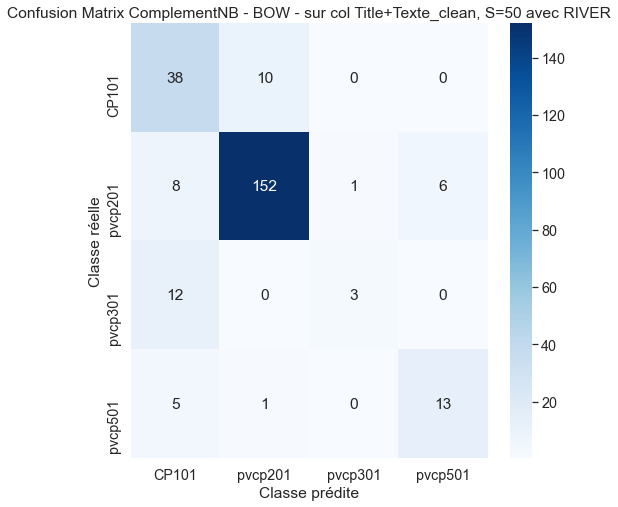

In [25]:
plot_matrice_confusion(X_test['Label vrai'], X_test['Label prédit'], title='ComplementNB - BOW - sur col Title+Texte_clean, S=50 avec RIVER')

In [29]:
# Dataframe regroupant tous les docs mal classés
df_erreurs = X_test[X_test['Label vrai']!= X_test['Label prédit']]
df_doc_erreur_CNB = df_erreurs[['title', 'texte', 'Label vrai', 'Label prédit',
                                'Proba CP101', 'Proba pvcp201', 'Proba pvcp301', 'Proba pvcp501','Probabilité/classe']]
print(df_doc_erreur_CNB.shape)

(43, 9)


In [30]:
df_doc_erreur_CNB

,title,texte,Label vrai,Label prédit,Proba CP101,Proba pvcp201,Proba pvcp301,Proba pvcp501,Probabilité/classe
80,2515-CP101-#SY2515.1-#D20200226-CONVOC AGO.pdf,"\n\nINL\nService courrier\n\nRogule 91 JAN, 2020\n\nCABINET BALZANO\n\nS.A.S. au capital de 200.000 € dont le siége social\n\nest situé 75/77, rue du pére Corentin 4 PARIS PARIS , Le 28 Janvier 2020\n(75014)\n\nService gestion : 01 45 40 66 99\n\nServices comptables : 01 45 40 90 66\n\nNégociation / Locations : 01 45 40 65 11\n\nTélécopie : 01 45 40 66 79\n\n| CONVOCATION A L’ASSEMBLEE GENERALE ORDINAIRE\n\nDU SYNDICAT DES COPROPRIETAIRES DE L’IMMEUBLE SIS\n\n \n\n \n\n \n\n \n\n \n\nMadame, Monsieur,\n\nNous vous informons que l'Assemblée Générale des copropriétaires aura lieu le :\n\nMERCREDI 26 FEVRIER 2020 à 18 h 30\nPAROISSE SAINT FRANCOIS D‘ASSISE - 92 RUE SADI CARNOT\n92170 VANVES\n\nVous trouverez ci-après la liste des majorités, l'ordre du jour, le projet de résolutions, le mandat de syndic, le\nbudget et les annexes.\n\nA l'effet de délibérer sur l'ordre du jour joint à la présente.\n\nEn conséquence, il est important que tous les copropriétaires soient présents ou repr...",CP101,pvcp201,0.0,1.0,0.0,0.0,"{'CP101': 5.580625244460613e-54, 'pvcp201': 1.0, 'pvcp501': 2.4599813079966142e-92, 'pvcp301': 5.274596060668715e-91}"
130,6418-CP101-#SY6418.1-#D20200205-CONVOC AGO.PDF,"RECOMMANDEE A.R. IMMEUBLE\n NEW WAVE\n 2 RUE GEORGES STEPHENSON\n 78180 MONTIGNY LE BRETONNEUX\n\n\n\n\n  Convocation à l’Assemblée générale ordinaire \n\n\nMadame, Mademoiselle, Monsieur,\n\nNous vous remercions de bien vouloir participer à l'Assemblée Générale des Copropriétaires qui se tiendra\nle :\n\n MERCREDI 5 FEVRIER 2020 à 18 H 00\n\nHOTEL MERCURE\n9 PLACE ETIENNE FRANCOIS CHOISEUL\n\n78180 MONTIGNY LE BRETONNEUX.\n\n\nà l'effet de délibérer sur l'ordre du jour joint.\n\nLes résolutions 4/ 11/14/15/16/17/18/21/23/24 nécessitent la majorité de l'article 25-1 de la loi.\nLes résolutions 12/13/22 nécessitent la majorité de l'article 25 de la loi.\nLes résolutions 10/20 nécessitent la majorité de l’article 26 de la loi\n\nEn con...",CP101,pvcp201,0.0,1.0,0.0,0.0,"{'CP101': 7.219367188939576e-17, 'pvcp201': 1.0, 'pvcp501': 3.0479171054492814e-79, 'pvcp301': 1.9757383054408122e-77}"
1239,6710-CP301-#SY6710.1-#D20200605-COR TRAVAUX.pdf,"Dossier :\nRésidence BRICHEBAY\n\n60300 SENLIS\n\n| Allée de la Bréhaigne — Avenue des Dix Cors\n\n5)\n\n77\n|\n\nÉ\IBay\n\nSyndic Gestion ay, Vente Pay\nserve courrier\n\nRegule 49 JUTE 2820\n\n \n\n \n\nDossier suivi par :\nGestionnaire : Olivia BAY\n\nolivia. bay@immobay.fr\n03.75.11.10.10\nAssistante : Amandine MINOS\n\n. amandine.minos@immobay, fr\n. 03.75.11.00.46\n\n \n\n \n\nIN'LI\n5 place de la Pyramide\n92800 PUTEAUX\n\nClermont, le 5 juin 2020\n\n \n\n \n\n \n\n \n\n \n\nMadame, Monsieur,\n\ndébuter.\n\ntravaux.\n\ndéroulement des travaux.\n\n \n\n \n\nAgence de Chantilly\n40 Av. du Maréchal Joffre 60500 CHANTILLY\n\nTél :03,44,74,30.53\n\nSiret : 877 856 575 COO15 — APE : 68317\nCarte professionnelle n°6001 2019 000 043 467 défivrée par la CC] de l'Oise\nGarantie inéncière souscrite auprès de la GALIAN pour un montant dé 360 O00 €\nResponsabiité civile professionnelle souscrite auprès de MMA\nAdhérent FNAIM\n\nNous venons vers vous en notre qualité de syndic de votre ré...",pvcp301,CP101,1.0,0.0,0.0,0.0,"{'CP101': 1.0, 'pvcp201': 5.503986577159742e-44, 'pvcp501': 2.722131796536239e-20, 'pvcp301': 1.8413705935258075e-19}"
1290,2023-CP501-#SY2023.1-#D20191210-CR CS.pdf,"ROMs DA\n\nÂo: con\n\neS\n\nRenclapps\n\nLE PARC DE BURY — 95580 MARGENCY\n\n \n\n \n\n \n\nIIMA\n\nPROCES VERBAL DU CONSEIL SYNDICAL DU\n\nMARDI 10 DECEMBRE 2019 A 20 H 30\n\n \n\nSe sont réunis les membres du Conseil Syndical dans la salle de l'ancienne cantine, sur convocation qui\nleur a été régulièrement adressée par le cabinet de gestion GUY SOUTOUL, syndic.\n\nPrésents :\n\nMessieurs LEMAIRE, ROCHE, SOULLARD, FLETY, JAILLET\nMesdames GIRARD, ROCHEROLLES, SCHULLER, VILLE, L

In [43]:
print(df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'CP101'].shape[0])
print(df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'pvcp201'].shape[0])
print(df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'pvcp301'].shape[0])
print(df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'pvcp501'].shape[0])

10
15
12
6


### <span class="bg-success">Résultats: Fichier en csv</span>

In [32]:
df_doc_erreur_CNB.to_excel('docs_mal-classes_Acc_82-7_ComplementNB_BOW_S50.xlsx', index=False)

In [67]:
df_doc_erreur_CNB.to_csv('docs_mal-classes_Acc_82-7_ComplementNB_BOW_S50.csv', index=False)

## <span class="bg-info">3. % d'erreurs par classe</span>

In [48]:
df_erreur_CP101 = df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'CP101']
df_erreur_pvcp201 = df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'pvcp201']
df_erreur_pvcp301 = df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'pvcp301']
df_erreur_pvcp501 = df_doc_erreur_CNB[df_doc_erreur_CNB['Label vrai'] == 'pvcp501']

In [65]:
df_erreur_pvcp501[['title', 'Label vrai', 'Label prédit', 'Proba CP101', 'Proba pvcp201', 'Proba pvcp301', 'Proba pvcp501']]

,title,Label vrai,Label prédit,Proba CP101,Proba pvcp201,Proba pvcp301,Proba pvcp501
1290,2023-CP501-#SY2023.1-#D20191210-CR CS.pdf,pvcp501,pvcp201,0.0,1.0,0.0,0.0
1320,6285-CP501-#SY1560.1-#D20200810-CR CS-CR expertise DO.pdf,pvcp501,CP101,1.0,0.0,0.0,0.0
1285,2500-CP501-#SY2500.1-#D201911-CR CS novembre 2019.pdf,pvcp501,CP101,1.0,0.0,0.0,0.0
1345,MULT-CP501-#D20210106-HP 1506-2484-CR CS.pdf,pvcp501,CP101,1.0,0.0,0.0,0.0
1281,MULT-CP501-#D20191119-CR CS-HP 4387-6235-Convoc des membres du CS le 10032020.pdf,pvcp501,CP101,1.0,0.0,0.0,0.0
1344,2500-CP501-#SY2500.1-#D20201200-CR CS 2019-2020.pdf,pvcp501,CP101,1.0,0.0,0.0,0.0


In [35]:
df_erreurs_classe = pd.read_excel ('percent_erreur_classe.xlsx')
df_erreurs_classe.style.background_gradient(subset='%_Erreurs/classe')

,Classe,Total,Nb_erreurs,%_Erreurs/classe
0,CP101,48,10,20.8
1,pvcp201,167,15,9.0
2,pvcp301,15,12,80.0
3,pvcp501,19,6,31.6


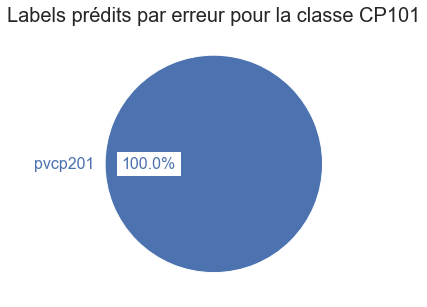

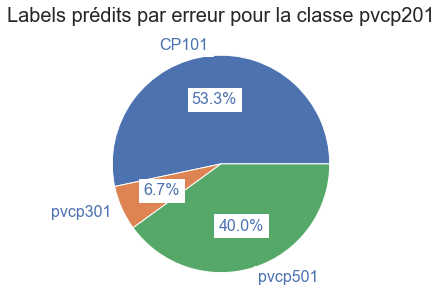

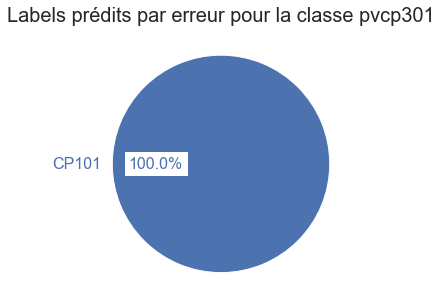

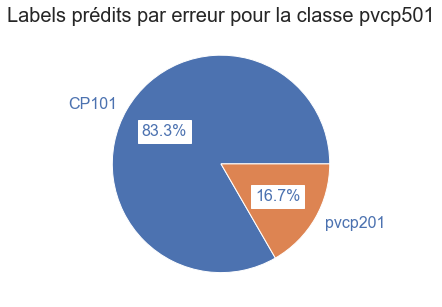

In [58]:
list_df = [df_erreur_CP101, df_erreur_pvcp201,df_erreur_pvcp301,df_erreur_pvcp501]
list_classe = ['CP101', 'pvcp201','pvcp301','pvcp501']
i=0
for df in list_df :
    df_plot = df.groupby('Label prédit').agg({'texte':'count'})
    df_plot = df_plot.reset_index()
    plt.figure(figsize=(5,5))
    plt.title(f'Labels prédits par erreur pour la classe {list_classe[i]}', size=20)
    wedges, texts, autotexts = plt.pie(df_plot.texte, labels = df_plot['Label prédit'], autopct='%1.1f%%', textprops={'fontsize': 16, 'color' : 'b', 'backgroundcolor' : 'w'})
    ax = plt.gca()
    i+=1
    plt.show()